In [1]:
import imageio as igio
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy as scpy

In [2]:
def my_mse( A, B):
#     if( A.shape != B.shape):
#         print('Both matrixes are of same dimensions\n')
    counter = 0
    for i in range(0,A.shape[0]):
        for j in range(0,A.shape[1]):
            counter += (A[i,j]- B[i,j])*(A[i,j]- B[i,j])
    print( np.sqrt(counter)/(A.shape[0]*A.shape[1]) )

In [3]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # the np.where() function returns the indices for all coordinates 
        # in some array matching the condition. In this case, all pixels
        # that have value 'i'
        pixels_value_i = np.where(A == i)
        
        #print(pixels_value_i)  # uncomment to print array of coordinates
        
        # by counting how many coordinates the np.where function returned, 
        # we can assign it at the respective histogram bin
        # this is done by getting the size of the vector of coordinates
        hist[i] = pixels_value_i[0].shape[0]
            
    return(hist)

In [4]:
#size of the denoising filter kernel (if type 1) or size of degradation function (if
#type 2), k ∈ [3, 5, 7, 9, 11],
#Afterwards, if the type of filter is 1 (denoising), get the following input:
# • mode for denoising mode = "average" or "robust",
# Otherwise, if the type of filter is 2 (deblurring), then
# • sigma for the degradation function σ > 0.

def my_min(im):
    m_min = 256
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if( im[i,j] < m_min ):
                m_min = im[i,j]
    return m_min
    
def my_max(im):
    m_max = -1
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if( im[i,j] > m_max ):
                m_max = im[i,j]
    return m_max

def my_scale( img_orig, img_dest  ):
    img_scaled = np.zeros(img_dest.shape)
    
    a = my_min(img_orig)
    b = my_max(img_orig)
    
    img_dest_min = my_min(img_dest)
    img_dest_max = my_max(img_dest)
    
    for i in range(img_dest.shape[0]):
        for j in range(img_dest.shape[1]):
            img_scaled[i,j] = (b - a)*(img_dest[i,j]-img_dest_min)/(img_dest_max-img_dest_min) + a
    
    return img_scaled

def my_fun(name_reference, name_degraded, F, gamma, size_denoising_filter, denoising_type, sigma ):
    
    img_reference =igio.imread(name_reference)
    print(img_reference.shape)
    img_degraded =igio.imread(name_degraded)
    print(img_degraded.shape)
    
    img_f = np.zeros(img_degraded.shape)
    print(img_f.shape)
    
    ##Copy of values with no filter passing
    img_f[0, 0:img_reference.shape[1]-1] = img_reference[0, 0:img_reference.shape[1]-1]
    img_f[img_reference.shape[0]-1, 0:img_reference.shape[1]-1] = img_reference[img_reference.shape[0]-1, 0:img_reference.shape[1]-1]
    
    img_f[0:img_reference.shape[0]-1, 0] = img_reference[0:img_reference.shape[0]-1, 0]
    img_f[0:img_reference.shape[0]-1, img_reference.shape[1]-1] = img_reference[0:img_reference.shape[0]-1, img_reference.shape[1]-1]
    print(img_f)
    
    ##Clarify disp_n is only calculates on [0,1/6*m], [0,1/6*n]
    x_d = int(np.floor(img_degraded.shape[0]/6)) ##Clarify what is m or n???
    y_d = int(np.floor(img_degraded.shape[1]/6))
    
    n_range = np.zeros([1, x_d*y_d])
    idx = 0
    disp_n = -1
    for x in range(0,x_d):
        for y in range(0,y_d):
            n_range[0, idx] = img_degraded[x,y]
            idx += 1
        if(denoising_type == 'average'):
            disp_n = np.std(n_range)
        elif(denoising_type == 'robust'):
            disp_n = np.percentile(n_range, 75, interpolation='higher') - np.percentile(n_range, 25, interpolation='lower')
    
    ##Error Checking disp_n
    if disp_n == 0:
        disp_n = 1
    
    print('disp_n ', disp_n)
    
    centr_l = -1
    ##Adaptative Denoising
    for i in range(1, img_degraded.shape[0]-2):
        for j in range(1, img_degraded.shape[1]-2):
            
            ##Calculate disp_l
            val = int(np.floor(size_denoising_filter.shape[1]/2))
                
            l_range = np.zeros([1, int(size_denoising_filter.shape[0]*size_denoising_filter.shape[1]) - 1])
            
            idx = 0
            
            inc_i = -val
#             print('i j : ', i, j)
            for n_i in range(0, size_denoising_filter.shape[0]):
                inc_j = -val
                for n_j in range(0, size_denoising_filter.shape[1]):
                    if( not(n_i == 1 & n_j == 1) ):
                        l_range[0, idx] = img_degraded[i + inc_i, j + inc_j]
#                         print(l_range)
                        idx += 1
                    inc_j += 1
                inc_i += 1
            
            if(denoising_type == 'average'):
                centr_l = np.std(l_range)
            elif(denoising_type == 'robust'):
                centr_l = np.percentile(l_range, 75, interpolation='higher') - np.percentile(l_range, 25, interpolation='lower')
            
            disp_l = np.std(l_range)
            
            ##Error checking
            if (disp_l == 0):
                disp_l = disp_n
            
            ##Calculate centr_l
            centr_l = 0
            if(denoising_type == 'average'):
                centr_l = np.average(l_range)
            elif(denoising_type == 'robust'):
                centrl_l = np.median(l_range)
            
            
            img_f[i,j] = img_degraded[i,j] - gamma * disp_n/disp_l * (img_degraded[i,j] - centr_l)
            
    igio.imwrite('im_ori.png', img_f.astype('uint8'))
    
    img_f = my_scale(img_reference, img_f)
    
#     igio.imwrite('im_norm.png', img_f.astype('uint8'))

In [5]:
import time
start = time.time()

my_fun(name_reference='camera_saltpepper.png', name_degraded='camera_saltpepper.png', F=1, gamma=0.5, size_denoising_filter=np.zeros([3,3]), denoising_type='average', sigma = 0 )

end = time.time()
print(end - start)

(256, 256)
(256, 256)
(256, 256)
[[156. 159. 158. ... 151. 152. 152.]
 [255.   0.   0. ...   0.   0.   0.]
 [156.   0.   0. ...   0.   0. 152.]
 ...
 [114.   0.   0. ...   0.   0. 114.]
 [  0.   0.   0. ...   0.   0. 113.]
 [121. 126. 130. ...   0. 130.   0.]]
disp_n  36.071365707944594
11.27588176727295


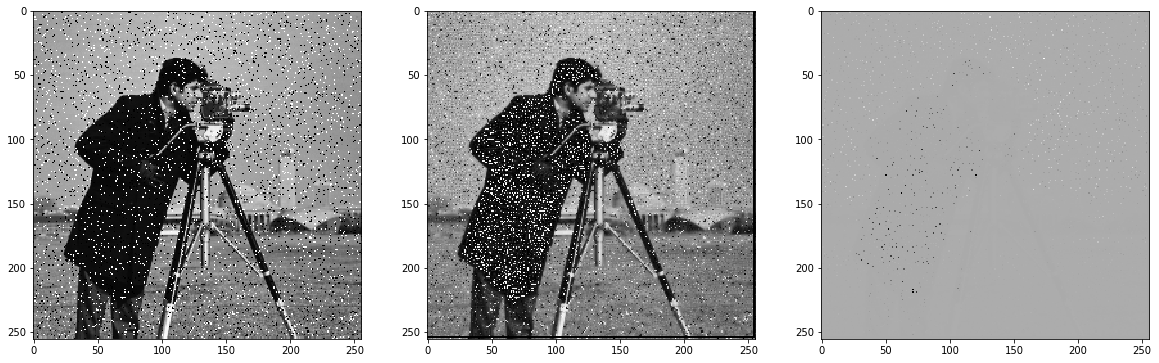

In [6]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
im1 = igio.imread('camera_saltpepper.png')
fig = plt.imshow(im1, cmap = plt.get_cmap(name = 'gray'))
# plt.bar(range(256), histogram(im, 256))
# plt.axis([0, 256, 0, 2500])
# plt.xlabel('Graylevel / intensity')
# plt.ylabel('Frequency')

plt.subplot(1,3,2)
im2 = igio.imread('im_ori.png')
fig = plt.imshow(im2, cmap = plt.get_cmap(name = 'gray'))
# plt.bar(range(256), histogram(im, 256))
# plt.axis([0, 256, 0, 2500])
# plt.xlabel('Graylevel / intensity')
# plt.ylabel('Frequency')

plt.subplot(1,3,3)
im3 = igio.imread('im_norm.png')
fig = plt.imshow(im3, cmap = plt.get_cmap(name = 'gray'))
# plt.colorbar()

In [7]:
def test_myscale():
    test1 = np.zeros([10,10])
    test2 = np.zeros([10,10])

    for i in range(test1.shape[0]):
        for j in range(test1.shape[1]):
            test1[i,j] = np.mod(i*j,26)
    print(test1)

    for i in range(test1.shape[0]):
        for j in range(test1.shape[1]):
            test2[i,j] = np.mod(i*j,50) + 20
    print(test2)

    print(my_scale(test1,test2))

In [8]:
import scipy

def gaussian_filter(k=3,sigma=1.0):
    arx=np.arange((-k//2)+1.0,(k//2)+1.0)
    x,y=np.meshgrid(arx,arx)
    filt=np.exp(-(1/2)*(np.square(x)+np.square(y))/np.square(sigma))
    return filt/np.sum(filt)

In [9]:
g_filter = gaussian_filter()

In [10]:
from scipy.fftpack import fft, ifft
im1_fft = fft(im1)
# print(im1_fft.shape)
# print(im1_fft[0,0].real)

##Visualization
# r_list = np.zeros([10,10])
# r_list[0,0] = 0
# r_list[1,1] = 255

# im1_fft = my_scale(r_list,im1_fft.real)
# im1_fft_tmp = np.copy(im1_fft)
# im1_fft[0:128, 0:128] = im1_fft_tmp[128:256, 128:256]
# im1_fft[128:256, 128:256] = im1_fft_tmp[0:128, 0:128]

# im1_fft[0:128, 128:256] = im1_fft_tmp[128:256, 0:128]
# im1_fft[128:256, 0:128] = im1_fft_tmp[0:128, 128:256]

# plt.figure(figsize=(10,10))
# plt.imshow(im1_fft, cmap = plt.get_cmap(name = 'gray'), vmin = 0, vmax = 255)

In [11]:
def fun3(im, size_filter, w):
    
    III = np.zeros([ im.shape[0]+2, im.shape[1]+2])
        
    III[0,1:III.shape[1]-1] = im[0,:] ##top row
    III[III.shape[0]-1,1:III.shape[1]-1] = im[im.shape[0]-1,:].shape ##down row

    III[1:III.shape[0]-1,0] = im[:,0].shape ##first column
    III[1:III.shape[0]-1,III.shape[1]-1] = im[:,im.shape[1]-1].shape ##last column

    #corners
    III[0,0] = im[0,0] #left up
    III[III.shape[0]-1,0] = im[im.shape[0]-1,0] #left down
    III[0,III.shape[1]-1] = im[0,im.shape[1]-1] #right up
    III[III.shape[0]-1,III.shape[1]-1] = im[im.shape[0]-1,im.shape[1]-1] #right down

    III[1:III.shape[0]-1,1:III.shape[1]-1] = im[0:im.shape[0],0:im.shape[1]] #inside matrix

    ww = w
        
    II_c = np.zeros([im.shape[0],im.shape[1]])

    for i in range(1,III.shape[0]-1):
        for j in range(1,III.shape[1]-1):
            c = 0
            i_x = i - 1 
            for x in range(0,ww.shape[0]):
                i_y = j - 1
                for y in range(0,ww.shape[1]):
                    c += ww[x,y] * III[i_x,i_y]
                    i_y += 1
                i_x += 1
            II_c[i-1,j-1] = c
    II_c = II_c.astype('uint8')

    return II_c

In [38]:
f = np.zeros(im1_fft.shape)
H_ = np.zeros(im1_fft.shape)

H_u  = fun3(im1_fft.real, 3, g_filter)
H_u_ = fun3(im1_fft.imag, 3, g_filter)

In [63]:
p_u = np.array([ [0, -1, 0], [-1, 4, -1], [0, -1, 0] ])
p_u = fft(p_u)
P_u = np.ndarray(im1_fft.shape, dtype=np.complex128)

for i in range(im1_fft.shape[0]):
    for j in range(im1_fft.shape[1]):
        P_u[i,j] = 0 + 0j
P_u[0:3,0:3] = p_u
gamma = 0.5
# print(P_u)

In [72]:
for i in range(f.shape[0]):
    for j in range(f.shape[1]):
        f[i,j] = ( H_u_[i,j] / ( H_u[i,j]*H_u[i,j] + gamma * P_u[i,j]*P_u[i,j] + 0.001 ) ) * im1_fft[i,j].real 

/home/jecs89/anaconda3/envs/tutorialConda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jecs89/anaconda3/envs/tutorialConda/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
f

array([[ 1.04063473e+07, -9.05359701e+02, -3.69184686e+02, ...,
         5.26615416e+02, -1.82815223e+02, -3.18254765e+08],
       [ 5.32430108e+04, -1.95447152e+02,  1.09087435e+02, ...,
        -2.37714987e+02,  6.09554166e+00, -5.70747442e+02],
       [ 2.00425901e+04, -4.39408552e+03, -2.33350348e+03, ...,
         2.25395701e+01, -1.24623514e+02, -1.71168951e+03],
       ...,
       [ 5.93173866e+04, -2.09091958e+03,  4.64722432e+03, ...,
         1.16596032e+03,  3.51470747e+02, -6.69225396e+02],
       [ 2.07883158e+04, -2.50042016e+02,  1.65430377e+08, ...,
         1.78010934e+03,  4.76238965e+08, -1.10223534e+02],
       [ 4.88767000e+09, -3.26905950e+02,  6.46099130e+02, ...,
         4.18340692e+03,  1.33433516e+03, -2.81363470e+02]])

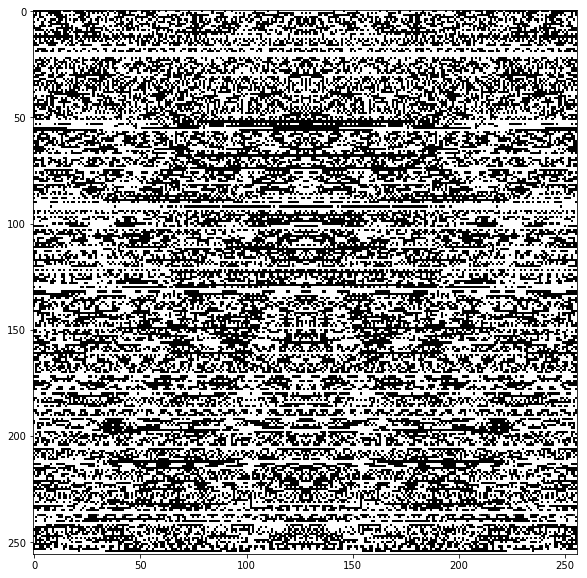

In [76]:
f_inv = ifft(f)
plt.figure(figsize=(10,10))
plt.imshow(f_inv.real, cmap = plt.get_cmap(name = 'gray'), vmin = 0, vmax = 255)